Il foglio sarà diviso in 2 parti:

1 - **Autoencoder** 
      
      Allenamento della rete su un dataset generale con immagini a colori RGB  32x32

2 - **Transfer Learning**

      Retraining, partendo dal modello creato in precedenza, su un dataset più specifico
      

**1 - AUTOENCODER**

Librerie

In [1]:
import numpy as np
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.models import Sequential
from keras.datasets import cifar10
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

import tensorflow as tf
import numpy as np

import os
import random
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential, Model
from keras.callbacks import TensorBoard 

from keras.layers import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import cv2
import requests

from PIL import Image

Set up delle funzioni per visualizzare l'output


In [2]:
# The next three methods to visualize input/output of our model side-by-side
def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))

Download del dataset

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train/255
x_test = x_test/255

print(type(x_train))
print(type(x_test))

print(x_train.shape)
print(x_test.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)


**Test - RGB to Cielab - Cielab to B&W**

In [4]:
x_test_BandW = np.ones_like(x_test)

i=0

for img in x_test:
  img = rgb2lab(x_test[i])
  #B&W
  img[...,1] = img[...,2] = 0
  #img = lab2rgb(img)
  x_test_BandW[i] = img
  i = i + 1


x_test_BandW = (x_test_BandW + [0, 128, 128]) / [100, 255, 255]

**Train - RBG to CieLAB**


In [5]:
x_train_CieLAB = np.ones_like(x_train)

i=0

for img in x_train:
  img = rgb2lab(x_train[i])
  #img[...,0].reshape(img[...,0].shape+(1,))
  #img[...,1:] = img[...,1:] / 128
  #img = lab2rgb(img)
  x_train_CieLAB[i] = img
  i = i + 1

x_train_CieLAB = (x_train_CieLAB + [0, 128, 128]) / [100, 255, 255]

**Train - RBG to CieLAB - B&W**


In [6]:
x_train_lab_BandW = np.ones_like(x_train)


i=0

for img in x_train:
  img = rgb2lab(x_train[i])
  #B&W
  img[...,1] = img[...,2] = 0
  #img[...,0].reshape(img[...,0].shape+(1,))
  #img[...,1:] = img[...,1:] / 128
  #img = lab2rgb(img)
  x_train_lab_BandW[i] = img
  i = i + 1

x_train_lab_BandW = (x_train_lab_BandW + [0, 128, 128]) / [100, 255, 255]

Creazione del modello con i suoi layer

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32


model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 32)         128       
 hNormalization)                                        

Training

In [8]:
model.fit(x_train_lab_BandW,
          x_train_CieLAB, 
          epochs=50, batch_size=100)

Epoch 1/50
500/500 [==============================] - 23s 22ms/step - loss: 0.0044 - accuracy: 0.6905
Epoch 2/50
500/500 [==============================] - 11s 23ms/step - loss: 0.0028 - accuracy: 0.7181
Epoch 3/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0025 - accuracy: 0.7246
Epoch 4/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0024 - accuracy: 0.7274
Epoch 5/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0023 - accuracy: 0.7300
Epoch 6/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0023 - accuracy: 0.7326
Epoch 7/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0022 - accuracy: 0.7355
Epoch 8/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0022 - accuracy: 0.7371
Epoch 9/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0022 - accuracy: 0.7387
Epoch 10/50
500/500 [==============================] - 11s 22ms/step - loss: 0.002

Prediction

In [9]:
x_test_BandW = x_test_BandW[:400]
#noise = np.random.normal(0, NOISE, x_test.shape)
pred_imgs = model.predict(x_test_BandW)

Trasformare CieLAB in RGB

In [10]:
x_test_BandW = (x_test_BandW) * [100, 255, 255]
x_test_BandW = (x_test_BandW - [0, 128, 128])

i=0

for img in x_test_BandW:
  img = x_test_BandW[i]
  #B&W
  #img[...,1] = img[...,2] = 0
  img = lab2rgb(img)
  x_test_BandW[i] = img
  i = i + 1

In [11]:
pred_imgs = (pred_imgs) * [100, 255, 255]
pred_imgs = (pred_imgs - [0, 128, 128])


i=0

for img in pred_imgs:
  img = pred_imgs[i]
  img = lab2rgb(img)
  pred_imgs[i] = img
  i = i + 1

Output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


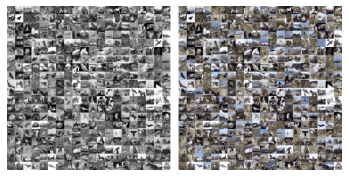

In [12]:
plt.imshow(sbscompare(x_test_BandW, pred_imgs, 20, 20))
#plt.imshow(sbscompare(x_test, pred_imgs, 20, 20))
plt.axis('off')
plt.rcParams["figure.figsize"] = [100,100]
plt.show()

**2 - Transfer Learning**

In [13]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.callbacks import LearningRateScheduler

Download dataset specifico

In [14]:
# Opening file for reading in binary mode
with open('/content/drive/MyDrive/Tesi/DataSet/CartelliStradali/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


In [15]:
x_test = None
x_train = None
x_test_BandW = None
x_train_CieLAB = None
x_train_lab_BandW = None
pred_imgs = None

**Test - RGB to Cielab - Cielab to B&W**

In [16]:

x_test_BandW = np.ones_like(data['x_test'])

i=0

for img in data['x_test']:
  img = rgb2lab(img)
  #B&W
  img[...,1] = img[...,2] = 0
  #img = lab2rgb(img)
  x_test_BandW[i] = img
  i = i + 1


x_test_BandW = (x_test_BandW + [0, 128, 128]) / [100, 255, 255]

print(x_test_BandW.shape)

(12630, 32, 32, 3)


**Train - RGB to CieLAB**

In [17]:
x_train_CieLAB = np.ones_like(data['x_train'])

i=0

for img in data['x_train']:
  img = rgb2lab(img)
  #img[...,0].reshape(img[...,0].shape+(1,))
  #img[...,1:] = img[...,1:] / 128
  #img = lab2rgb(img)
  x_train_CieLAB[i] = img
  i = i + 1

x_train_CieLAB = (x_train_CieLAB + [0, 128, 128]) / [100, 255, 255]

**Train - RBG to CieLAB - B&W**

In [ ]:
x_train_lab_BandW = np.ones_like(data['x_train'])


i=0

for img in data['x_train']:
  img = rgb2lab(img)
  #B&W
  img[...,1] = img[...,2] = 0
  #img[...,0].reshape(img[...,0].shape+(1,))
  #img[...,1:] = img[...,1:] / 128
  #img = lab2rgb(img)
  x_train_lab_BandW[i] = img
  i = i + 1

x_train_lab_BandW = (x_train_lab_BandW + [0, 128, 128]) / [100, 255, 255]

Training

In [ ]:
model.fit(x_train_lab_BandW,
          x_train_CieLAB, 
          epochs=50, batch_size=100)

Prediction

In [ ]:
x_test_BandW = x_test_BandW[:400]
pred_imgs = model.predict(x_test_BandW)

Trasformare CieLAB in RGB

In [ ]:
x_test_BandW = (x_test_BandW) * [100, 255, 255]
x_test_BandW = (x_test_BandW - [0, 128, 128])

i=0

for img in x_test_BandW:
  img = x_test_BandW[i]
  #B&W
  #img[...,1] = img[...,2] = 0
  img = lab2rgb(img)
  x_test_BandW[i] = img
  i = i + 1

In [ ]:
pred_imgs = (pred_imgs) * [100, 255, 255]
pred_imgs = (pred_imgs - [0, 128, 128])


i=0

for img in pred_imgs:
  img = pred_imgs[i]
  img = lab2rgb(img)
  pred_imgs[i] = img
  i = i + 1

Output

In [ ]:
plt.imshow(sbscompare(x_test_BandW, pred_imgs, 20, 20))
#plt.imshow(sbscompare(x_test, pred_imgs, 20, 20))
plt.axis('off')
plt.rcParams["figure.figsize"] = [60,60]
plt.show()